In [ ]:
# import sys
# print("Using Python executable:", sys.executable)

# # 현재 커널 환경에 pip로 설치
# !{sys.executable} -m pip install --upgrade pip
# !{sys.executable} -m pip install 

In [ ]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.expand_frame_repr', False)

In [1]:
import os
import pandas as pd
import numpy as np
test = pd.read_csv('./test/test.csv', encoding='CP949')
df23 = pd.read_csv('./data/train_subway23.csv', encoding='CP949')
df22 = pd.read_csv('./data/train_subway22.csv', encoding='CP949')
df21 = pd.read_csv('./data/train_subway21.csv', encoding='CP949')
df = pd.concat([df21, df22, df23], axis=0, ignore_index=True)
t = pd.read_excel('./data/환승역.xlsx', names =['Line','station_name','transfer'], header=0)
address = pd.read_csv('./data/result_address.csv', encoding='CP949')
subway_13 = pd.DataFrame({'역명':['성수E', '응암S','불암산']
             ,'주소':['서울 성동구 아차산로 100','서울 은평구 증산로 477','서울 노원구 상계로 305']})
address = pd.concat([address, subway_13], axis=0).reset_index(drop=True)
df.shape

(16369332, 15)

In [2]:
address.columns=['station_name','address']
address.station_name = address.station_name.apply(lambda x: x.split('(')[0].strip() if '(' in x else x)
address.address = address.address.apply(lambda x: x.split()[0] if '서울' not in x else x.split()[1])
addr = address['address']  
address['address'] = np.where(addr.str.contains('인천'), '인천',np.where(addr.str.contains('경기'), '경기', addr))

print(df.shape)
df.head()

(16369332, 15)


,TM,Line,station_number,station_name,Direction,STN,TA,WD,WS,RN_DAY,RN_HR1,HM,SI,ta_chi,Congestion
0,2021010100,1,150,서울역,상선,419,-9.6,291.1,3.3,0.0,0.0,-99.0,-99.0,-12.6,0.0
1,2021010101,1,150,서울역,상선,419,-9.7,284.6,2.0,0.0,0.0,-99.0,-99.0,-9.8,0.0
2,2021010105,1,150,서울역,상선,419,-9.3,124.7,2.4,0.0,0.0,-99.0,-99.0,-10.3,1.0
3,2021010106,1,150,서울역,상선,419,-9.3,126.2,1.7,0.0,0.0,-99.0,-99.0,-10.1,2.0
4,2021010107,1,150,서울역,상선,419,-9.1,145.7,1.3,0.0,0.0,-99.0,-99.0,-9.7,3.0


# 대회 공지사항에 따라 df 이상치 드롭
- 남위례를 제외한 한대앞~오이도역 구간은 내부 프로그램 오류로 인하여 22년 6월 13일까지 4호선 재차인원이 누락되었습니다. 
- 해당기간동안 한대앞~오이도역을 이용하는 인원은 모두 수인분당선을 이용하는것으로 기록되었습니다.
- 남위례역은 21년 12월 18일에 개통하였으며, 프로그램 내부에 개통사항 반영이 늦어져 혼잡도가 0으로 산출된 것으로 확인됩니다.

In [3]:
import os
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from holidayskr import year_holidays
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import joblib
import warnings

warnings.filterwarnings('ignore')

def preprocessing(data, t, address, is_train=True, known_stations=None):
    data = data.copy()
    # 1)  → datetime
    data['TM'] = data['TM'].astype(str)
    data['TM'] = pd.to_datetime(data['TM'], format='%Y%m%d%H')

    # 2) 범주형 변환
    cat_columns = ['Line', 'station_number', 'STN', 'station_name', 'Direction']
    for col in cat_columns:
        data[col] = data[col].astype('category')

    # 3) 결측값 placeholder
    data['WD']     = data['WD'].where(data['WD'] >=   0, np.nan)
    data['WS']     = data['WS'].replace(-99.0,          np.nan)
    data['RN_DAY'] = data['RN_DAY'].replace(-99.0,      np.nan)
    data['RN_HR1'] = data['RN_HR1'].replace(-99.0,      np.nan)
    data['TA']     = data['TA'].replace(-99.0,          np.nan)
    data['ta_chi'] = data['ta_chi'].replace(-99.0,      np.nan)
    data['SI']     = data['SI'].replace(-99.0,          np.nan)
    data['HM']     = data['HM'].replace(-99.0,          np.nan)
    data = data.drop(columns='SI', axis=1)
    
    # 5) station_name 교정
    data['station_name'] = data['station_name'].astype(str).replace({
        '당고개': '불암산',
        '자양(뚝섬한강공원)': '자양',
        '신촌(지하)': '신촌'
    })
    # 6) 신설역 변수 생성
    new_station_list = {'구리', '다산', '동구릉', '별내', '암사역사공원', '장자호수공원'}
    known_stations = data['STN'].unique()
    
    # 7) 신규관측소 변수
    if is_train:
        # 학습 데이터는 기준이 될 known_stations를 만들어 두고
        data['신설역'] = 0
        data['신규관측소'] = 0
        이상치_4호선_역명 = ['한대앞','중앙','고잔','초지','안산','신길온천','정왕','오이도','개봉'] # 개봉은 그냥 여기 추가해서 처리함
        이상치_8호선_역명 = ['남위례']
        
        pattern_8 = '|'.join(이상치_8호선_역명)
        pattern_4 = '|'.join(이상치_4호선_역명)
        
        mask_8 = (data['Line'] == 8) & data['station_name'].str.contains(pattern_8) & (data['TM'] < '2022-12-31')
        mask_4 = (data['Line'] == 4) & data['station_name'].str.contains(pattern_4) & (data['TM'] <= '2022-12-31')
        print('train셋 공지사항 이상치 ',(data.shape[0] - data[~(mask_8 | mask_4)].reset_index(drop=True).shape[0])/data.shape[0],'% 제거')
        data = data[~(mask_8 | mask_4)].reset_index(drop=True)

    else:
        # test에서는 train에서 넘어온 known_stations를 이용해 플래그 처리
        data['신설역'] = data['station_name'].apply(lambda x: 0 if x in known_stations else 1)
        data['신규관측소'] = data['STN'].apply(lambda x: 0 if x in known_stations else 1)

    # 7 ) 선형 보간
    cols_to_interp = ['TA', 'WD', 'WS', 'RN_DAY', 'RN_HR1', 'ta_chi','HM']
    data[cols_to_interp] = data[cols_to_interp].interpolate(method='linear', limit_direction='both')
    data[cols_to_interp] = data[cols_to_interp].interpolate(method='linear', limit_direction='both')
    
    # 8) 외부 테이블 병합
    data = data.merge(t, on=['Line','station_name'], how='left')
    data['transfer'] = data['transfer'].fillna(0).astype(int)
    data = data.merge(address, on=['station_name'], how='left')

    # 9) 파생 변수
    data['year']         = data['TM'].dt.year - 2021
    data['month']        = data['TM'].dt.month
    data['day']          = data['TM'].dt.day
    data['hour']         = data['TM'].dt.hour
    data['weekday']      = data['TM'].dt.dayofweek
    data['week_of_month']= (data['day'] - 1) // 7 + 1
    data['week_of_year'] = data['TM'].dt.isocalendar().week.astype(int)
    data['day_of_year']  = data['TM'].dt.dayofyear

    # 10) 공휴일 플래그
    holidays = []
    for yr in [2021,2022,2023,2024]:
        holidays += [d for d,_ in year_holidays(yr)]
    data['is_holiday']            = data['TM'].dt.date.isin(holidays).astype(int)
    data['is_day_before_holiday'] = data['TM'].dt.date.shift(-1).isin(holidays).astype(int)
    data['is_day_after_holiday']  = data['TM'].dt.date.shift(1).isin(holidays).astype(int)

    # 11) 주말 플래그
    data['is_weekend'] = data['weekday'].isin([5,6]).astype(int)

    # 12) 시간대 범주
    data['time_period'] = np.where(data['hour'].isin([7,8,9]), '출근',
                             np.where(data['hour'].isin([17,18,19]), '퇴근',
                             np.where((data['hour']>9)&(data['hour']<17), '낮',
                             np.where((data['hour']>19)&(data['hour']<21), '저녁',
                             '밤'))))
    direction_order   = ['상선','하선','외선','내선']
    time_period_order = ['밤','출근','낮','저녁','퇴근']
    data['Direction']   = data['Direction'].astype(
        CategoricalDtype(categories=direction_order, ordered=True)
    ).cat.codes
    data['time_period'] = data['time_period'].astype(
        CategoricalDtype(categories=time_period_order, ordered=True)
    ).cat.codes

    # 13) 주기성 sin/cos (24h, 7d, 31d, 5w, 52w, 365d)
    data['sin_hod'] = np.sin(2*np.pi * data['hour']        / 24)
    data['cos_hod'] = np.cos(2*np.pi * data['hour']        / 24)
    data['sin_dow'] = np.sin(2*np.pi * data['weekday']     / 7)
    data['cos_dow'] = np.cos(2*np.pi * data['weekday']     / 7)
    data['sin_dom'] = np.sin(2*np.pi * data['day']         / 31)
    data['cos_dom'] = np.cos(2*np.pi * data['day']         / 31)
    data['sin_wom'] = np.sin(2*np.pi * data['week_of_month'] / 5)
    data['cos_wom'] = np.cos(2*np.pi * data['week_of_month'] / 5)
    data['sin_woy'] = np.sin(2*np.pi * data['week_of_year']  / 52)
    data['cos_woy'] = np.cos(2*np.pi * data['week_of_year']  / 52)
    data['sin_doy'] = np.sin(2*np.pi * data['day_of_year']   / 365)
    data['cos_doy'] = np.cos(2*np.pi * data['day_of_year']   / 365)

    
    return data

# 전처리
df   = preprocessing(df,   t, address, is_train=True)
known_stations = df['STN'].unique()
test = preprocessing(test, t, address,
                               is_train=False,
                               known_stations=known_stations)

le_m = LabelEncoder()
le_d = LabelEncoder()
df['month'] = le_m.fit_transform(df['month'])
df['day'] = le_d.fit_transform(df['day'])
test['month'] = le_m.transform(test['month'])
test['day'] = le_d.transform(test['day'])

print('전처리 완료')

# feature / target 정의
ordered_cols = ['Direction', 'time_period']
cat_cols     = ['Line'
                , 'station_number'
                , 'address'
               ] + ordered_cols
num_cols = [
    'HM','RN_DAY','RN_HR1','TA','WD','WS'
    ,'STN'
    ,'sin_dom','cos_dom','sin_dow','cos_dow','sin_hod','cos_hod'
    ,'sin_wom','cos_wom','sin_woy','cos_woy','sin_doy','cos_doy'
    ,'day','day_of_year','hour'
    ,'is_day_before_holiday','is_day_after_holiday','is_holiday','is_weekend'
    ,'month','transfer','week_of_month','week_of_year','weekday','year'
    ,'신설역', '신규관측소'
]
feature_cols = num_cols + ordered_cols + cat_cols
target_col   = 'Congestion'

results = []
final_results = []
print('완료')

train셋 공지사항 이상치  0.009340271185165039 % 제거
전처리 완료
완료


In [ ]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import joblib
import os

# 모델 저장 디렉토리
results = []
final_results = []

model_dir = './models'
os.makedirs(model_dir, exist_ok=True)

for line in sorted(df['Line'].unique()):
    #if line!=8: continue
    print(f"\n📘 [Line {line}] 모델 학습 시작")

    df_line = df[df['Line'] == line].copy()
    test_line = test[test['Line'] == line].copy()

    # 범주형 처리
    for col in ['Line', 'STN','address']:
        df_line[col] = df_line[col].astype('category')
        test_line[col] = test_line[col].astype('category')

    # ✅ 시간 기준 정렬 (핵심)
    df_line = df_line.sort_values('TM')

    # feature & target 추출
    X = df_line[feature_cols]
    y = df_line[target_col].astype(int)
    X_test = test_line[feature_cols]

    # 인코딩
    # 원-핫 인코딩
    X_enc = pd.get_dummies(X, columns=cat_cols, drop_first=False, prefix=cat_cols)
    X_test_enc = pd.get_dummies(X_test, columns=cat_cols, drop_first=False, prefix=cat_cols)

    # ✅ 컬럼 정렬 및 누락된 컬럼 채움
    X_enc = X_enc.loc[:, ~X_enc.columns.duplicated()]
    X_test_enc = X_test_enc.loc[:, ~X_test_enc.columns.duplicated()]
    X_test_enc = X_test_enc.reindex(columns=X_enc.columns, fill_value=0)
    
    # 정규화
    mm = MinMaxScaler()
    X_scaled = mm.fit_transform(X_enc)
    X_test_scaled = mm.transform(X_test_enc)

    # ✅ 시간 순 분할 (train:val = 8:2)
    split_idx = int(len(X_scaled) * 0.8)
    X_train = X_scaled[:split_idx]
    X_val   = X_scaled[split_idx:]
    y_train = y.values[:split_idx]
    y_val   = y.values[split_idx:]

    # 모델 정의
    model = xgb.XGBRegressor(
        n_estimators=1500,
        learning_rate=0.01,
        max_depth=12,
        subsample=0.9,
        colsample_bytree=0.9,
        min_child_weight=1,
        gamma=0.5,
        reg_alpha=0.3,
        reg_lambda=0.8,
        tree_method='hist',
        early_stopping_rounds=100,
        random_state=42
    )

    # 모델 학습
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=100)

    # 성능 평가
    val_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    r2 = r2_score(y_val, val_pred)
    print(f"✅ RMSE: {rmse:.4f}, R²: {r2:.4f}")
    results.append({'Line': line, 'RMSE': rmse, 'R2': r2})

    # 예측
    y_pred = np.round(model.predict(X_test_scaled)).astype(int)
    y_pred = np.where(y_pred < 0, 0, y_pred)
    temp = test_line[['hour', 'Line', 'station_number']].copy()
    temp['예측혼잡도'] = y_pred
    final_results.append(temp)

    # 모델 저장
    model_path = f"./models/xgb_line{line}.pkl"
    joblib.dump(model, model_path)

# 🔁 결과 통합 및 저장
final_df = pd.concat(final_results)
output_df = final_df[['예측혼잡도']].rename(columns={'예측혼잡도': 'Congestion'})

output_df.to_csv(
    './test/250206-2.csv',
    index=False,
    encoding='utf-8'
)

# 📊 성능 요약
results_df = pd.DataFrame(results)
print(results_df)

In [19]:
gap = pd.read_csv('./test/250206-2.csv') # 내 데터터
gap.shape

import os
제출 = pd.read_csv('./test/minjeong.csv') # 민정언니 데이터

import numpy as np

# 마스크 생성
from sklearn.metrics import root_mean_squared_error
rmse = mean_squared_error(
    제출['Congestion'],
    gap['Congestion'],
    squared=False      # squared=False 하면 RMSE 를 직접 계산해 줌
)

print(f"RMSE: {rmse:.4f}")

RMSE: 4.4358


In [5]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import joblib
import os

# 모델 저장 디렉토리
results = []
final_results = []

model_dir = './models'
os.makedirs(model_dir, exist_ok=True)

for line in sorted(df['Line'].unique()):
    #if line!=8: continue
    print(f"\n📘 [Line {line}] 모델 학습 시작")

    df_line = df[df['Line'] == line].copy()
    test_line = test[test['Line'] == line].copy()

    # 범주형 처리
    for col in ['Line', 'STN','address']:
        df_line[col] = df_line[col].astype('category')
        test_line[col] = test_line[col].astype('category')

    # ✅ 시간 기준 정렬 (핵심)
    df_line = df_line.sort_values('TM')

    # feature & target 추출
    X = df_line[feature_cols]
    y = df_line[target_col].astype(int)
    X_test = test_line[feature_cols]

    # 인코딩
    # 원-핫 인코딩
    X_enc = pd.get_dummies(X, columns=cat_cols, drop_first=False)
    X_test_enc = pd.get_dummies(X_test, columns=cat_cols, drop_first=False)

    # ✅ 컬럼 정렬 및 누락된 컬럼 채움
    X_enc = X_enc.loc[:, ~X_enc.columns.duplicated()]
    X_test_enc = X_test_enc.loc[:, ~X_test_enc.columns.duplicated()]
    X_test_enc = X_test_enc.reindex(columns=X_enc.columns, fill_value=0)
    
    # 정규화
    mm = MinMaxScaler()
    X_scaled = mm.fit_transform(X_enc)
    X_test_scaled = mm.transform(X_test_enc)

    # ✅ 시간 순 분할 (train:val = 8:2)
    split_idx = int(len(X_scaled) * 0.8)
    X_train = X_scaled[:split_idx]
    X_val   = X_scaled[split_idx:]
    y_train = y.values[:split_idx]
    y_val   = y.values[split_idx:]

    # 모델 정의
    model = xgb.XGBRegressor(
        n_estimators=1500,
        learning_rate=0.01,
        max_depth=12,
        subsample=0.9,
        colsample_bytree=0.9,
        min_child_weight=1,
        gamma=0.5,
        reg_alpha=0.3,
        reg_lambda=0.8,
        tree_method='hist',
        early_stopping_rounds=100,
        random_state=42
    )

    # 모델 학습
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=100)

    # 성능 평가
    val_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    r2 = r2_score(y_val, val_pred)
    print(f"✅ RMSE: {rmse:.4f}, R²: {r2:.4f}")
    results.append({'Line': line, 'RMSE': rmse, 'R2': r2})

    # 예측
    y_pred = np.round(model.predict(X_test_scaled)).astype(int)
    y_pred = np.where(y_pred < 0, 0, y_pred)
    temp = test_line[['hour', 'Line', 'station_number']].copy()
    temp['예측혼잡도'] = y_pred
    final_results.append(temp)

    # 모델 저장
    model_path = f"./models/xgb_line{line}.pkl"
    joblib.dump(model, model_path)

# 🔁 결과 통합 및 저장
final_df = pd.concat(final_results)
output_df = final_df[['예측혼잡도']].rename(columns={'예측혼잡도': 'Congestion'})

output_df.to_csv(
    './test/250206-2.csv',
    index=False,
    encoding='utf-8'
)

# 📊 성능 요약
results_df = pd.DataFrame(results)
print(results_df)


📘 [Line 1] 모델 학습 시작
[0]	validation_0-rmse:20.70751
[100]	validation_0-rmse:11.78788
[200]	validation_0-rmse:7.98964
[300]	validation_0-rmse:6.09318
[400]	validation_0-rmse:5.31395
[500]	validation_0-rmse:5.03185
[600]	validation_0-rmse:4.87072
[700]	validation_0-rmse:4.73128
[800]	validation_0-rmse:4.62443
[900]	validation_0-rmse:4.53106
[1000]	validation_0-rmse:4.45998
[1100]	validation_0-rmse:4.40581
[1200]	validation_0-rmse:4.35184
[1300]	validation_0-rmse:4.31310
[1400]	validation_0-rmse:4.28321
[1499]	validation_0-rmse:4.25936
✅ RMSE: 4.2594, R²: 0.9569

📘 [Line 2] 모델 학습 시작
[0]	validation_0-rmse:22.00235
[100]	validation_0-rmse:12.74030
[200]	validation_0-rmse:10.33255
[300]	validation_0-rmse:9.91108
[400]	validation_0-rmse:9.27608
[500]	validation_0-rmse:8.94794
[600]	validation_0-rmse:8.75157
[700]	validation_0-rmse:8.60930
[800]	validation_0-rmse:8.47642
[900]	validation_0-rmse:8.39128
[1000]	validation_0-rmse:8.32070
[1100]	validation_0-rmse:8.26138
[1200]	validation_0-rmse:8

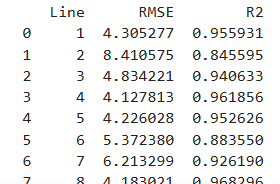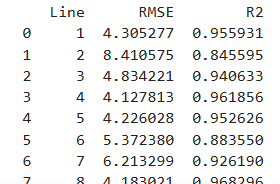

In [8]:
gap = pd.read_csv('./test/250206.csv') # 내 데터터
gap.shape

import os
제출 = pd.read_csv('./test/250206-1.csv') # 민정언니 데이터

import numpy as np

# 마스크 생성
from sklearn.metrics import root_mean_squared_error
rmse = mean_squared_error(
    제출['Congestion'],
    gap['Congestion'],
    squared=False      # squared=False 하면 RMSE 를 직접 계산해 줌
)

print(f"RMSE: {rmse:.4f}")

RMSE: 2.3777


In [4]:
# # 2) 프로파일 리포트 생성
# from pycaret.regression import *
# from ydata_profiling import ProfileReport

# profile = ProfileReport(
#     df,
#     title="My Data Profiling Report",  # 리포트 제목
#     explorative=True,                  # 자세한 분석 모드
#     minimal=False                       # 최소 리포트 모드 해제
# )

# # 3) 결과를 HTML 파일로 저장
# profile.to_file("data_report.html")

In [ ]:
from pycaret.regression import (
    setup, compare_models, tune_model,
    finalize_model, predict_model, save_model
)

os.makedirs('./models_pycaret', exist_ok=True)
final_preds = []

for line in sorted(df['Line'].unique()):
    if line!=7: continue 
    print(f"\n▶▶ Line {line} AutoML 시작")

    # 4-1) Line subset
    train_line = df[df['Line']==line].copy()
    test_line  = test[test['Line']==line].copy()
    train_line['Congestion'] = train_line['Congestion'].astype(int)
    # 4-2) PyCaret setup
    exp = setup(
        data=train_line,
        target='Congestion',
        session_id=42,
        verbose=1
    )

    # 4-3) 모델 비교 & 선택
    best      = compare_models(verbose=1)           # 기본 교차검증으로 최적 모델 선택
    compare_results = pull()             # compare_models 결과 DataFrame
    print(compare_results)
    save_model(best, f'./models_pycaret/pycaret_base_line{line}')
    
    tuned     = tune_model(best, verbose=1)           # 선택된 모델 하이퍼튜닝
    tune_results = pull()                # tune_model 결과 DataFrame
    print(tune_results)
    final_mod = finalize_model(tuned)      # 튜닝된 모델 파이널라이즈
    
    # 4-4) 테스트셋 예측
    preds = predict_model(final_mod, data=test_line)
    print(pull())
    # PyCaret 회귀의 경우 예측 결과는 컬럼명 'Label'에 담겨 있습니다.
    preds = preds.rename(columns={'Label':'Congestion_pred'}) \
                 [['hour','Line','station_number','Congestion_pred']]
    preds['Congestion_pred'] = preds['Congestion_pred'].astype(int)
    final_preds.append(preds)
    
    # 4-5) 모델 저장
    save_model(final_mod, f'./models_pycaret/pycaret_tuned_line{line}')

# ─────────────────────────────────────────────────────────────────────────────
# 5) 결과 통합 및 저장
# ─────────────────────────────────────────────────────────────────────────────
submission = pd.concat(final_preds).reset_index(drop=True)
submission = submission[['hour','Line','station_number','Congestion_pred']] \
             .rename(columns={'Congestion_pred':'Congestion'})

submission.to_csv('./test/250206_pycaret_submission.csv',
                  index=False, encoding='utf-8')

print("\n✅ AutoML 완료, 제출 파일 생성: ./test/250206_pycaret_submission.csv")

In [17]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from holidayskr import year_holidays

def preprocessing(data, t, address):
    # 1) TM → datetime, 정렬
    data['TM'] = data['TM'].astype(str)
    data['TM'] = pd.to_datetime(data['TM'], format='%Y%m%d%H')

    # 2) 범주형 변환
    cat_columns = ['Line', 'station_number', 'STN', 'station_name', 'Direction']
    for col in cat_columns:
        data[col] = data[col].astype('category')

    # 3) 결측값 처리용 placeholder
    data['WD'] = data['WD'].where(data['WD'] >= 0, np.nan)
    data['WS'] = data['WS'].replace(-99.0, np.nan)
    data['RN_DAY'] = data['RN_DAY'].replace(-99.0, np.nan)
    data['RN_HR1'] = data['RN_HR1'].replace(-99.0, np.nan)
    data['TA'] = data['TA'].replace(-99.0, np.nan)
    data['ta_chi'] = data['ta_chi'].replace(-99.0, np.nan)
    data['SI'] = data['SI'].replace(-99.0, np.nan)
    data['HM'] = data['HM'].replace(-99.0, np.nan)

    # 4) 이진 플래그화
    data['SI'] = data['SI'].notna().astype(int)

    # 5) station_name 일부 교정
    data['station_name'] = data['station_name'].astype(str).replace({
        '당고개': '불암산',
        '자양(뚝섬한강공원)': '자양',
        '신촌(지하)': '신촌'
    })

    # 6) 외부 테이블 병합
    data = pd.merge(data, t, on=['Line','station_name'], how='left')
    data['transfer'] = data['transfer'].fillna(0).astype(int)

    data = pd.merge(data, address, on=['station_name'], how='left')

    # 7) 키, 시간 파생
    data['key']   = data['Line'].astype(str) + '_' + data['station_name'].astype(str) + '_' + data['Direction'].astype(str)
    data['year']  = data['TM'].dt.year - 2021
    data['month'] = data['TM'].dt.month
    data['day']   = data['TM'].dt.day
    data['hour']  = data['TM'].dt.hour
    data['weekday']      = data['TM'].dt.weekday
    data['week_of_month']= (data['TM'].dt.day.sub(1) // 7) + 1
    data['week_of_year'] = data['TM'].dt.isocalendar().week.astype(int)
    data['day_of_year']  = data['TM'].dt.dayofyear

    # 8) 공휴일 플래그
    holidays = []
    for yr in [2021, 2022, 2023, 2024]:
        holidays += [d for d, _ in year_holidays(yr)]
    data['date'] = data['TM'].dt.date
    data['is_holiday'] = data['date'].isin(holidays).astype(int)
    data['is_day_before_holiday'] = data['date'].shift(-1).isin(holidays).astype(int)
    data['is_day_after_holiday']  = data['date'].shift(1).isin(holidays).astype(int)
    data.drop(columns=['date'], inplace=True)

    # 9) 주말 플래그
    data['is_weekend'] = data['weekday'].isin([5,6]).astype(int)

    # 10) 시간대 범주화
    data['time_period'] = np.where(data['hour'].isin([7,8,9]), '출근',
                             np.where(data['hour'].isin([17,18,19]), '퇴근',
                             np.where((data['hour']>9)&(data['hour']<17), '낮',
                             np.where((data['hour']>19)&(data['hour']<21), '저녁',
                             '밤'))))

    # 순서형 범주 인코딩
    direction_order   = ['상선','하선','외선','내선']
    time_period_order = ['밤','출근','낮','저녁','퇴근']
    data['Direction']   = data['Direction'].astype(
        CategoricalDtype(categories=direction_order, ordered=True)
    ).cat.codes
    data['time_period'] = data['time_period'].astype(
        CategoricalDtype(categories=time_period_order, ordered=True)
    ).cat.codes

    # 11) 주기성 변수 (sin/cos)
    data['sin_hod'] = np.sin(data['hour'] * (2*np.pi/24))
    data['cos_hod'] = np.cos(data['hour'] * (2*np.pi/24))
    data['sin_dow'] = np.sin(data['weekday'] * (2*np.pi/7))
    data['cos_dow'] = np.cos(data['weekday'] * (2*np.pi/7))
    # data['sin_dom'] = np.sin(data['day'] * (2*np.pi/31))
    # data['cos_dom'] = np.cos(data['day'] * (2*np.pi/31))
    # data['sin_wom'] = np.sin(data['week_of_month'] * (2*np.pi/5))
    # data['cos_wom'] = np.cos(data['week_of_month'] * (2*np.pi/5))
    # data['sin_woy'] = np.sin(data['week_of_year'] * (2*np.pi/52))
    # data['cos_woy'] = np.cos(data['week_of_year'] * (2*np.pi/52))
    data['sin_doy'] = np.sin(data['day_of_year'] * (2*np.pi/365))
    data['cos_doy'] = np.cos(data['day_of_year'] * (2*np.pi/365))


    # 12) 선형 보간
    cols_to_fill = ['WD','RN_DAY','RN_HR1','TA','ta_chi','SI','HM','WS']
    data[cols_to_fill] = data[cols_to_fill].interpolate(method='linear', limit_direction='both')

    print('보간 후 남은 결측값:\n', data[cols_to_fill].isna().sum())
    return data

# 사용 예시
df_processed  = preprocessing(df,  t, address)
test_processed = preprocessing(test, t, address)
print('완료')

보간 후 남은 결측값:
 WD        0
RN_DAY    0
RN_HR1    0
TA        0
ta_chi    0
SI        0
HM        0
WS        0
dtype: int64
보간 후 남은 결측값:
 WD        0
RN_DAY    0
RN_HR1    0
TA        0
ta_chi    0
SI        0
HM        0
WS        0
dtype: int64
완료


In [18]:
# ▶ 수치형 피처 목록
ordered_cols = ['Direction', 'time_period']
cat_cols = ['Line', 'address', 'station_name']
num_cols = [
    'HM', 'RN_DAY', 'RN_HR1', 'SI', 'STN', 'TA', 'WD', 'WS',
    'cos_dom', 'cos_dow', 'cos_doy', 'cos_hod', 'cos_wom', 'cos_woy', 'day', 'day_of_year',
    'hour', 'is_day_after_holiday', 'is_day_before_holiday', 'is_holiday', 'is_weekend',
    'month', 'sin_dom', 'sin_dow', 'sin_doy', 'sin_hod', 'sin_wom', 'sin_woy',
    'ta_chi', 'transfer', 'week_of_month', 'week_of_year', 'weekday', 'year','station_number'
]
cat_cols = cat_cols + ordered_cols
features = num_cols + ordered_cols + cat_cols + ['Congestion']

# ▶ 연도별 분리
# train_df = pd.concat([df[df['year'] == 0], df[df['year'] == 1]])[features]
# val_df = df[df['year'] == 2][features]

# # ▶ category 인코딩
# for col in ['Line', 'station_name', 'address']:
#     train_df[col] = train_df[col].astype('category')
#     val_df[col] = val_df[col].astype('category')
#     val_df[col] = val_df[col].cat.set_categories(train_df[col].cat.categories)
#     train_df[col] = train_df[col].cat.codes
#     val_df[col] = val_df[col].cat.codes

In [5]:
# X_train = train_df.drop(columns=['Congestion','STN'])
# X_val = val_df.drop(columns=['Congestion','STN'])

# y_train = train_df['Congestion'].values
# y_val = val_df['Congestion'].values

In [ ]:
# # ▶ 수치형 피처 목록
# ordered_cols = ['Direction', 'time_period']
# cat_cols = ['Line', 'address', 'station_name']
# num_cols = [
#     'HM', 'RN_DAY', 'RN_HR1', 'SI', 'STN', 'TA', 'WD', 'WS', 'Station_number',
#     'cos_dom', 'cos_dow', 'cos_doy', 'cos_hod', 'cos_wom', 'cos_woy', 'day', 'day_of_year',
#     'hour', 'is_day_after_holiday', 'is_day_before_holiday', 'is_holiday', 'is_weekend',
#     'month', 'sin_dom', 'sin_dow', 'sin_doy', 'sin_hod', 'sin_wom', 'sin_woy',
#     'ta_chi', 'transfer', 'week_of_month', 'week_of_year', 'weekday', 'year'
# ]

# features = num_cols + ordered_cols + cat_cols + ['Congestion']
# df = df[features]

In [19]:
###### 전처리
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

# 모델
import xgboost as xgb
import joblib

# 결과 저장용 리스트
results = []
final_results = []

# 경고 제거 (선택)
import warnings
warnings.filterwarnings('ignore')

# feature & target 추출
feature_cols = features
target_col = 'Congestion'

# 🚇 Line별 모델 학습 및 예측
for line in sorted(df_processed['Line'].unique()):
    print(f"\n📘 [Line {line}] 모델 학습 시작")
   # if line!=8: continue
    df_line = df_processed[df_processed['Line'] == line].copy()
    test_line = test_processed[test_processed['Line'] == line].copy()

    # 범주형 처리
    for col in cat_cols:
        df_line[col] = df_line[col].astype('category')
        test_line[col] = test_line[col].astype('category')

    # ✅ hour 기준 정렬 (핵심)
    df_line = df_line.sort_values('TM')

    
    X = df_line[feature_cols]
    y = df_line[target_col].astype(int)
    X_test = test_line[feature_cols]

    # 인코딩
    if line ==8:
        # 1️⃣ 원-핫 인코딩
        X_enc = pd.get_dummies(X, columns=cat_cols, drop_first=True)
        X_test_enc = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)
        
        # 2️⃣ 중복 컬럼 제거 (둘 다에서 확실히 제거)
        X_enc = X_enc.loc[:, ~X_enc.columns.duplicated()]
        X_test_enc = X_test_enc.loc[:, ~X_test_enc.columns.duplicated()]
        
        # 3️⃣ 테스트셋 컬럼을 학습셋 기준으로 정렬
        X_test_enc = X_test_enc.reindex(columns=X_enc.columns, fill_value=0)


    else:
        X_enc = pd.get_dummies(X, columns=cat_cols, drop_first=True)
        X_test_enc = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)
        X_test_enc = X_test_enc.reindex(columns=X_enc.columns, fill_value=0)

    # 정규화
    mm = MinMaxScaler()
    X_scaled = mm.fit_transform(X_enc)
    X_test_scaled = mm.transform(X_test_enc)

    # ✅ hour 순 분할 (train:val = 8:2)
    split_idx = int(len(X_scaled) * 0.8)
    X_train = X_scaled[:split_idx]
    X_val   = X_scaled[split_idx:]
    y_train = y.values[:split_idx]
    y_val   = y.values[split_idx:]

    # 모델 정의
    model = xgb.XGBRegressor(
        n_estimators=1500,
        learning_rate=0.01,
        max_depth=12,
        subsample=0.9,
        colsample_bytree=0.9,
        min_child_weight=1,
        gamma=0.5,
        reg_alpha=0.3,
        reg_lambda=0.8,
        tree_method='hist',
        early_stopping_rounds=100,
        random_state=42
    )

    # 모델 학습
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=100)

    # 성능 평가
    val_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    r2 = r2_score(y_val, val_pred)
    print(f"✅ RMSE: {rmse:.4f}, R²: {r2:.4f}")
    results.append({'Line': line, 'RMSE': rmse, 'R2': r2})

    # 예측
    y_pred = np.round(model.predict(X_test_scaled)).astype(int)
    y_pred = np.where(y_pred < 0, 0, y_pred)
    temp = test_line[['hour', 'Line', 'station_number']].copy()
    temp['예측혼잡도'] = y_pred
    final_results.append(temp)

    # 모델 저장
    save_dir= 'models'
    model_path = f"./{save_dir}/xgb_line{line}.pkl"
    joblib.dump(model, model_path)
test_processed
# 🔁 결과 통합 및 저장
final_df = pd.concat(final_results)
output_df = final_df[['예측혼잡도']].rename(columns={'예측혼잡도': 'Congestion'})

output_df.to_csv(
    './test/best_model_result.csv',
    index=False,
    encoding='utf-8'
)

# 📊 성능 요약
results_df = pd.DataFrame(results)
print(results_df)


📘 [Line 1] 모델 학습 시작
[0]	validation_0-rmse:15.06255
[100]	validation_0-rmse:6.02467
[200]	validation_0-rmse:2.83027
[300]	validation_0-rmse:1.97513
[400]	validation_0-rmse:1.81431
[500]	validation_0-rmse:1.74881
[600]	validation_0-rmse:1.70708
[700]	validation_0-rmse:1.66653
[800]	validation_0-rmse:1.64704
[900]	validation_0-rmse:1.63303
[1000]	validation_0-rmse:1.62178
[1100]	validation_0-rmse:1.61036
[1200]	validation_0-rmse:1.60333
[1300]	validation_0-rmse:1.59627
[1400]	validation_0-rmse:1.59027
[1499]	validation_0-rmse:1.58513
✅ RMSE: 1.5851, R²: 0.9874

📘 [Line 2] 모델 학습 시작
[0]	validation_0-rmse:15.86701
[100]	validation_0-rmse:6.14505
[200]	validation_0-rmse:2.65560
[300]	validation_0-rmse:1.39285
[400]	validation_0-rmse:0.96087
[500]	validation_0-rmse:0.81000
[600]	validation_0-rmse:0.74101
[700]	validation_0-rmse:0.69967
[800]	validation_0-rmse:0.66808
[900]	validation_0-rmse:0.64390
[1000]	validation_0-rmse:0.62680
[1100]	validation_0-rmse:0.61738
[1200]	validation_0-rmse:0.61

In [ ]:
gap = pd.read_csv('./test/best_model_result.csv')
gap.shape

import os
제출 = pd.read_csv('./test/250206.csv')

import numpy as np

# 마스크 생성
from sklearn.metrics import root_mean_squared_error
rmse = mean_squared_error(
    gap['Congestion'],
    sub['Congestion'],
    squared=False      # squared=False 하면 RMSE 를 직접 계산해 줌
)

print(f"RMSE: {rmse:.4f}")

In [35]:
제출.describe().round()

,Congestion
count,5834752.0
mean,192.0
std,47.0
min,127.0
25%,159.0
50%,170.0
75%,235.0
max,296.0
